In [57]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [58]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [60]:
def remove_stopwords(corpus) :
    stopwords = ['is','a','will','be']
    return [[word for word in sent.split() if word not in stopwords] for sent in corpus]        

In [62]:
corpus = remove_stopwords(corpus)
corpus

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [64]:
words = []
for token_sent in corpus :
    words.extend(token_sent)
words = list(set(words))
words

['girl',
 'prince',
 'wise',
 'queen',
 'king',
 'woman',
 'boy',
 'young',
 'strong',
 'man',
 'princess',
 'pretty']

In [67]:
word2index = {word:idx for idx, word in enumerate(words)}
word2index

{'girl': 0,
 'prince': 1,
 'wise': 2,
 'queen': 3,
 'king': 4,
 'woman': 5,
 'boy': 6,
 'young': 7,
 'strong': 8,
 'man': 9,
 'princess': 10,
 'pretty': 11}

In [72]:
WINDOW_SIZE = 2
skip_gram = []
for token_sent in corpus :
    for idx, center in enumerate(token_sent) :
        neighbors = token_sent[max(0, idx-WINDOW_SIZE): min(len(token_sent), idx+WINDOW_SIZE) + 1]
        for neighbor in neighbors :
            if neighbor is not center :
                skip_gram.append((center, neighbor))
skip_gram = pd.DataFrame(skip_gram, columns=('center', 'neighbor'))

In [73]:
skip_gram

,center,neighbor
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [74]:
ONE_HOT_DIM = len(words)
EMBED_DIM = 2

In [109]:
from tensorflow.keras.utils import to_categorical
X_train = to_categorical(skip_gram['center'].apply(lambda x : word2index[x]))
y_train = to_categorical(skip_gram['neighbor'].apply(lambda x : word2index[x]))

In [110]:
print(X_train.shape)
print(y_train.shape)

(52, 12)
(52, 12)


In [111]:
#모델링

In [112]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

In [113]:
initializer = tf.initializers.RandomNormal()
W1 = tf.Variable(initializer([ONE_HOT_DIM, EMBED_DIM]))
b1 = tf.Variable(initializer([1]))

In [114]:
W2 = tf.Variable(initializer([EMBED_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(initializer([1]))

In [115]:
def prediction(W1,b1, W2, b2) :
    hidden_layer = tf.add(tf.matmul(X_train, W1),b1)
    logits = tf.add(tf.matmul(hidden_layer, W2), b2)
    prediction = tf.nn.softmax(logits)
    return prediction

In [116]:
def loss(W1,b1, W2, b2) :
    loss = tf.reduce_mean(-tf.reduce_sum(y_train * tf.math.log(prediction(W1,b1, W2, b2)), axis=[1]))
    return loss

In [117]:
def grad(W1,b1, W2, b2) :
    with tf.GradientTape() as tape :
        loss_val = loss(W1,b1, W2, b2)
    return tape.gradient(loss_val, [W1,b1, W2, b2])

In [118]:
train_step = 20000
learning_rate = 5e-2

In [119]:
print("Initial loss: {:.3f}".format(loss(W1,b1, W2, b2)))

Initial loss: 2.485


In [120]:
for i in range(train_step) :
    dW1, db1, dW2, db2 = grad(W1,b1, W2, b2)
    W1.assign_sub(dW1 * learning_rate)
    b1.assign_sub(db1 * learning_rate)
    W2.assign_sub(dW2 * learning_rate)
    b2.assign_sub(db2 * learning_rate)
    if i % 1000 == 0 :
        print("Loss at step {:03d}: {:.3f}".format(i, loss(W1,b1, W2, b2)))
print("Final loss: {:.3f}".format(loss(W1,b1, W2, b2)))

Loss at step 000: 2.485
Loss at step 1000: 2.298
Loss at step 2000: 1.903
Loss at step 3000: 1.844
Loss at step 4000: 1.819
Loss at step 5000: 1.803
Loss at step 6000: 1.790
Loss at step 7000: 1.778
Loss at step 8000: 1.767
Loss at step 9000: 1.757
Loss at step 10000: 1.748
Loss at step 11000: 1.739
Loss at step 12000: 1.732
Loss at step 13000: 1.726
Loss at step 14000: 1.721
Loss at step 15000: 1.718
Loss at step 16000: 1.715
Loss at step 17000: 1.712
Loss at step 18000: 1.709
Loss at step 19000: 1.707
Final loss: 1.705


In [123]:
print(W1 + b1)

tf.Tensor(
[[ 2.3071878  -0.01303673]
 [ 1.9740348   6.0266733 ]
 [ 5.6248417  -0.49641192]
 [ 0.8823047  -0.33437812]
 [ 0.0849911   0.9751713 ]
 [ 0.26660717 -0.26163292]
 [ 0.08280146  1.4055536 ]
 [ 0.04665613  0.1749363 ]
 [-0.04476166  5.757821  ]
 [ 1.4532039   3.6260486 ]
 [ 4.312635    1.1300274 ]
 [ 4.1164637  -1.8865409 ]], shape=(12, 2), dtype=float32)


In [125]:
vectors = (W1 + b1).numpy()

,x1,x2
0,2.307188,-0.013037
1,1.974035,6.026673
2,5.624842,-0.496412
3,0.882305,-0.334378
4,0.084991,0.975171
5,0.266607,-0.261633
6,0.082801,1.405554
7,0.046656,0.174936
8,-0.044762,5.757821
9,1.453204,3.626049


In [137]:
w2v_df = pd.concat([
            pd.Series(words, name='word'),
            pd.DataFrame(vectors, columns=['x1','x2'])
        ], axis=1)
w2v_df

,word,x1,x2
0,girl,2.307188,-0.013037
1,prince,1.974035,6.026673
2,wise,5.624842,-0.496412
3,queen,0.882305,-0.334378
4,king,0.084991,0.975171
5,woman,0.266607,-0.261633
6,boy,0.082801,1.405554
7,young,0.046656,0.174936
8,strong,-0.044762,5.757821
9,man,1.453204,3.626049


In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

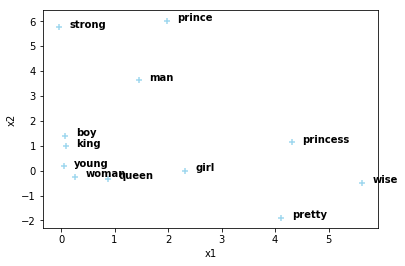

In [143]:
p1 = sns.regplot(data=w2v_df, x='x1', y='x2', fit_reg=False, marker='+', color='skyblue')
for line in range(0, w2v_df.shape[0]):
    p1.text(w2v_df.x1[line]+0.2, w2v_df.x2[line], w2v_df.word[line], 
            horizontalalignment='left', size='medium', color='black', weight='semibold')